# Featuretools Solution

<p style="margin:30px">
    <center>
    <img style="display:inline; margin-right:50px" width=50% src="https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png" alt="Featuretools" />
    </center>
</p>

In this notebook, we'll use Featuretools to engineer our features for predicting future daily average temperatures using historical temperature data. To see a simplified baseline run, check out the [Baseline Solution](Daily%20Temperature%201%20-%20Baseline%20Solution.ipynb).

Time series forecasting is different from other machine learning problems in that there is an inherent temporal ordering to the data, which means that special considerations will need to be taken into account during preprocessing, feature engineering, and model building. Featuretools provides an array of time series primitives that will handle the constraints necessary for time series featue engineering, allowing for the same ease of automation that is standard for other machine learning problem types in Featuretools.

## Configure Problem

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import utils
import featuretools as ft
import sklearn 

In [2]:
filepath = "dataset/DailyDelhiClimate.csv"

time_index = "date"
target_col = 'meantemp'

df = utils.read_data(filepath, time_index, target_col)
df.head(10)

,date,meantemp
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000
5,2013-01-06,7.000000
6,2013-01-07,7.000000
7,2013-01-08,8.857143
8,2013-01-09,14.000000
9,2013-01-10,11.000000


In this demo and in many time series problems, we're trying to predict a sequential series of values that are highly dependent on one another. We will exploit the fact that more recent observations are more predictive than more distant ones.

Therefore, we will use two concepts, `gap` and `window_length` that define a window over which we can engineer features. A full explanation of how these terms are used can be found in [Featuretools' Time Series Guide](). 

The first day we have access to will be after a `gap` of `9` days. The window will continue for `5` days. 

In [3]:
gap = 9
window_length = 5

## Data Splitting

Additionally, we'll want to have our data split up into training and testing data. Since the data has a strict temporal ordering, this will split the data at a defined point in time instead of randomly sampling from the data.

In [4]:
training_data, test_data = utils.get_train_test(df, gap)
test_data.head()

,date,meantemp
1111,2016-01-17,14.000000
1112,2016-01-18,13.266667
1113,2016-01-19,12.357143
1114,2016-01-20,12.066667
1115,2016-01-21,12.187500


## Feature Engineering with Featuretools

Now, we can use Featuretools like we would for any other machine learning problem. We'll set up an [EntitySet](https://featuretools.alteryx.com/en/stable/getting_started/using_entitysets.html), define our primitives, and run [DFS](https://featuretools.alteryx.com/en/stable/getting_started/afe.html).

In [5]:
# Adds an index column to the data, so the "temperatures"
# dataframe will have 3 columns
training_es = utils.set_up_entityset(training_data, id_='training_es', time_index=time_index)
test_es = utils.set_up_entityset(test_data, id_='test_es', time_index=time_index)

training_es

Entityset: training_es
  DataFrames:
    temperatures [Rows: 1102, Columns: 3]
  Relationships:
    No relationships

In [6]:
# Delaying primitives
delaying_primitives = [ft.primitives.NumericLag(periods=t + gap) for t in range(9)]

# Datetime primitives
datetime_primitives = ["Month", "Year"]

# Rolling primitive
# Min periods is a pandas parameter, and it just stops us from including partial calculations before the windows have 
# all the possible observations, so it's the window_length
min_periods = window_length

rolling_mean_primitive = ft.primitives.RollingMean(window_length, 
                                                   gap=gap,
                                                   min_periods=min_periods)

Now we'll make our DFS run and use the feature definitions in calculating the test feature matrix.

In [7]:
# DFS Run - calculates training feature matrix and the feature definitions
train_fm, feature_defs = ft.dfs(entityset=training_es, 
                                target_dataframe_name='temperatures', 
                                max_depth=1,
                                trans_primitives = datetime_primitives 
                                                 + delaying_primitives 
                                                 + [rolling_mean_primitive]
                                )

# Reuse the feature definitions for the test data
test_fm = ft.calculate_feature_matrix(feature_defs, test_es)

## Format data for modeling 

Again, we'll need to remove any null values in the data. In this case, all of our lagging primitives and our rolling 
mean primitive will have introduced NaNs that we need to remove. 

In [8]:
# Separate in to X and y objects for modeling
X_train = train_fm.dropna()
y_train = X_train.pop(target_col)

# Do the same for the test data 
X_test = test_fm.dropna()
y_test = X_test.pop(target_col)

X_train.head(13)

,MONTH(date),"NUMERIC_LAG(date, meantemp, periods=10)","NUMERIC_LAG(date, meantemp, periods=11)","NUMERIC_LAG(date, meantemp, periods=12)","NUMERIC_LAG(date, meantemp, periods=13)","NUMERIC_LAG(date, meantemp, periods=14)","NUMERIC_LAG(date, meantemp, periods=15)","NUMERIC_LAG(date, meantemp, periods=16)","NUMERIC_LAG(date, meantemp, periods=17)","NUMERIC_LAG(date, meantemp, periods=9)","ROLLING_MEAN(date, meantemp, window_length=5, gap=9, min_periods=5)",YEAR(date)
id,,,,,,,,,,,,
17,1,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000,14.000000,8.571429,2013
18,1,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,11.000000,9.571429,2013
19,1,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,15.714286,11.314286,2013
20,1,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,14.000000,12.714286,2013
21,1,14.000000,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,15.833333,14.109524,2013
22,1,15.833333,14.000000,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,12.833333,13.876190,2013
23,1,12.833333,15.833333,14.000000,15.714286,11.000000,14.000000,8.857143,7.000000,14.714286,14.619048,2013
24,1,14.714286,12.833333,15.833333,14.000000,15.714286,11.000000,14.000000,8.857143,13.833333,14.242857,2013
25,1,13.833333,14.714286,12.833333,15.833333,14.000000,15.714286,11.000000,14.000000,16.500000,14.742857,2013


## Model Building

The modeling step will be the exact same as the baseline run, but now we have twelve different features instead of just one!

In [9]:
reg = sklearn.ensemble.RandomForestRegressor(n_estimators=100)
reg.fit(X_train, y_train)

preds = reg.predict(X_test)
featuretools_score = sklearn.metrics.median_absolute_error(preds, y_test)
print('Median Abs Error: {:.2f}'.format(featuretools_score))

Median Abs Error: 1.66


We can see that the median absolute error has decreased relative to the baseline notebook, which means that this model is more accurate than the basline.

We can also take a look at the feature importances to see which contribute the most to the model.

In [10]:
high_imp_feats = utils.feature_importances(X_train, reg, feats=100)

1: ROLLING_MEAN(date, meantemp, window_length=5, gap=9, min_periods=5) [0.496]
2: NUMERIC_LAG(date, meantemp, periods=9) [0.318]
3: MONTH(date) [0.072]
4: NUMERIC_LAG(date, meantemp, periods=10) [0.025]
5: NUMERIC_LAG(date, meantemp, periods=17) [0.017]
6: NUMERIC_LAG(date, meantemp, periods=11) [0.016]
7: NUMERIC_LAG(date, meantemp, periods=15) [0.011]
8: NUMERIC_LAG(date, meantemp, periods=14) [0.010]
9: NUMERIC_LAG(date, meantemp, periods=16) [0.010]
10: NUMERIC_LAG(date, meantemp, periods=13) [0.009]
11: NUMERIC_LAG(date, meantemp, periods=12) [0.009]
12: YEAR(date) [0.006]
-----



These feature importances are extremly telling. The **most recent observation** we can access is one of the most important features, but we are able to improve upon the baseline model using the other features built from time series primitives. 

The rolling mean has the biggest impact on predictions, and if we graph our predictions over the rolling mean, we can see how similar they are. Let's take a look at a graph of the rolling mean and our predictions over the actual target values.

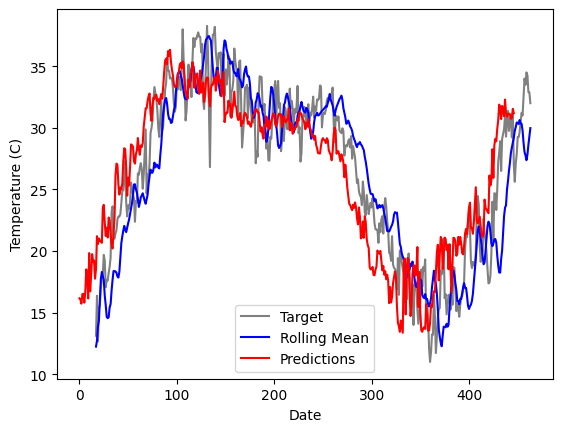

In [11]:
utils.graph_preds_mean_and_y(preds, 
                             X_test['ROLLING_MEAN(date, meantemp, window_length=5, gap=9, min_periods=5)'], 
                             y_test)

We see that we were able to improve upon our baseline model using Featuretools for feature engineering. Additionally, we can improve our model by playing around with the primitives that we used and by tuning our primitive parameters.

> We have a lot of control in Featuretools, and this ability to fine-tune the engineered features is where it shines. 

There might be situations, however, where we want to focus more on running several different pipelines and we wouldn't want to have so many granular control. In these situations, EvalML's time series regression shines. See the [EvalML Solution](Daily Temperature 3 - EvalML Solution.ipynb) to see this problem solved entirely in EvalML. 